### OpenStreetMap Data Preprocessing - Extract Landuse Feature

In [1]:
#Mount google drive for content synchronization

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Install libraries for geospatial data wrangling and analysis

#Geopandas for wrangling
!pip install geopandas


#Contextily for basemap plotting 
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip3 install contextily==1.0rc2


     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 11.0MB/s 
     |████████████████████████████████| 14.7MB 47.3MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 232 kB in 2s (116 kB/s)
Selecting previously unselected package libproj-dev:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...


### Step 1: Load OSM data for Landuse

In [3]:
import geopandas
import pandas as pd
import numpy as np
from geopandas import GeoDataFrame
import geopandas
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import contextily

landuse_df = geopandas.read_file('/content/drive/My Drive/Thesis/Bangladesh OSM Data/gis_osm_landuse_a_free_1.shp')
landuse_df.tail()

,osm_id,code,fclass,name,geometry
71904,777955130,7205,farm,None,"POLYGON ((89.75348 22.62318, 89.75349 22.62320..."
71905,777955131,7205,farm,None,"POLYGON ((89.75381 22.62307, 89.75382 22.62309..."
71906,777955132,7205,farm,None,"POLYGON ((89.75415 22.62299, 89.75416 22.62300..."
71907,777955133,7205,farm,None,"POLYGON ((89.75447 22.62287, 89.75448 22.62289..."
71908,778069519,7205,farm,None,"POLYGON ((89.68543 25.87470, 89.68566 25.87470..."


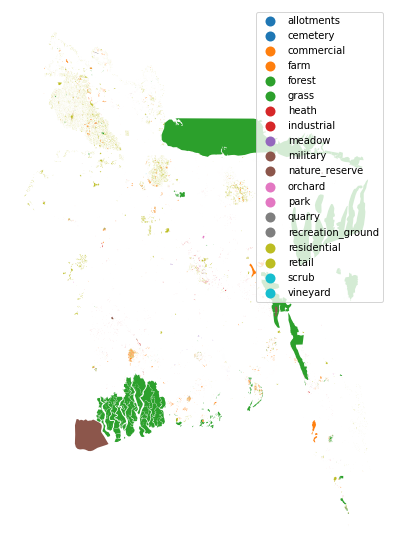

In [6]:
ax = landuse_df.to_crs(epsg=3857).plot(column = 'fclass', figsize=(12,10), legend = True)
#contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

In [0]:
#Load cluster data
import pandas as pd
clusters_df = pd.read_csv('/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_updated_new.csv')
clusters_df = geopandas.GeoDataFrame(clusters_df, geometry = geopandas.points_from_xy(clusters_df.longitude, clusters_df.latitude))
clusters_df.tail()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry
594,595,596,1.757480,U,24.900228,91.871489,POINT (91.87149 24.90023)
595,596,597,1.591590,U,24.904567,91.887165,POINT (91.88716 24.90457)
596,597,598,2.281590,U,24.886183,91.887103,POINT (91.88710 24.88618)
597,598,599,-0.042325,U,24.893073,91.906950,POINT (91.90695 24.89307)
598,599,600,1.242605,U,24.875934,91.895091,POINT (91.89509 24.87593)


OSM Point of Interest Data Feature Engineering 

In [0]:
#Separate Urban and Rural area clusters

clusters_rural = clusters_df[clusters_df['URBAN_RURA'] == 'R']
clusters_urban = clusters_df[clusters_df['URBAN_RURA'] == 'U']
clusters_rural.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry
0,0,1,-0.831240,R,21.965697,90.126312,POINT (90.12631 21.96570)
1,1,2,-0.739180,R,22.221232,90.348908,POINT (90.34891 22.22123)
2,2,3,-0.786210,R,22.191484,90.212539,POINT (90.21254 22.19148)
3,3,4,-0.447090,R,22.185481,90.167023,POINT (90.16702 22.18548)
4,4,5,-0.687435,R,22.311173,90.149822,POINT (90.14982 22.31117)


In [0]:
clusters_urban.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry
50,50,51,0.145555,U,22.302611,90.091872,POINT (90.09187 22.30261)
51,51,52,0.913850,U,22.053795,89.968962,POINT (89.96896 22.05380)
52,52,53,-0.261730,U,22.813022,90.191408,POINT (90.19141 22.81302)
53,53,54,-0.231740,U,22.691392,90.389866,POINT (90.38987 22.69139)
54,54,55,1.585980,U,22.691265,90.640443,POINT (90.64044 22.69127)


In [0]:
type(clusters_rural.geometry[0])

shapely.geometry.point.Point

In [0]:
#convert Rural clusters to buffers with 5km radius
clusters_rural.crs = {'init' :'epsg:4326'}
clusters_rural= clusters_rural.to_crs(epsg=3174)  
buffer_length_in_meters = (5 * 1000)

rural_buffer = clusters_rural.geometry.buffer(buffer_length_in_meters)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [0]:
len(rural_buffer)

392

In [0]:
#convert Urban clusters to buffers with 2km radius
clusters_urban.crs = {'init' :'epsg:4326'}
clusters_urban= clusters_urban.to_crs(epsg=3174)  
buffer_length = (2 * 1000)

urban_buffer = clusters_urban.geometry.buffer(buffer_length)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [0]:
len(urban_buffer)

207

In [0]:
#Convert roads_df to same crs as Urban and Rural clusters df
landuse_df = landuse_df.to_crs(epsg=3174)

In [0]:
#Helper function to calculate the area of landuse type within a buffer zone of a cluster

def landuse_within(buffer,landuse_df): 
  landuse_area_total_list = []
  landuse_area_mean_list = []
  landuse_area_pct_list = []
  for point in buffer:
    landuse_area = landuse_df.intersection(point).area
    landuse_area_total = landuse_area.sum() / (1000**2)
    landuse_area_mean = landuse_area.mean() / (1000**2)
    landuse_area_pct = landuse_area_total / point.area 
    landuse_area_total_list.append(landuse_area_total)
    landuse_area_mean_list.append(landuse_area_mean)
    landuse_area_pct_list.append(landuse_area_pct)
  return landuse_area_total_list, landuse_area_mean_list, landuse_area_pct_list


In [0]:
#Create list of different POIS types

landuse_type_name = landuse_df.fclass.unique()
landuse_type_name 

array(['park', 'forest', 'commercial', 'military', 'retail', 'cemetery',
       'industrial', 'residential', 'recreation_ground', 'nature_reserve',
       'farm', 'grass', 'meadow', 'orchard', 'quarry', 'scrub',
       'allotments', 'heath', 'vineyard'], dtype=object)

In [0]:
landuse_area_total_list, landuse_area_mean_list, landuse_area_pct_list = landuse_within(rural_buffer, landuse_df)


In [0]:
landuse_area_total_list = np.asarray(landuse_area_total_list)
landuse_area_mean_list = np.asarray(landuse_area_mean_list)
landuse_area_pct_list = np.asarray(landuse_area_pct_list)
clusters_rural[f"Landuse total"] = landuse_area_total_list
clusters_rural[f"Landuse mean"] = landuse_area_mean_list
clusters_rural[f"Landuse proportion"] = landuse_area_pct_list

In [0]:
import pickle
with open('clusters_rural_landuse', 'wb') as fp:
    pickle.dump(clusters_rural, fp)

with open('clusters_rural_landuse', 'rb') as fp:
  clusters_rural_landuse = pickle.load(fp)

clusters_rural_landuse.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Landuse total,Landuse mean,Landuse proportion
0,0,1,-0.831240,R,21.965697,90.126312,POINT (8280551.707 12256784.033),1.277760,1.776912e-05,1.629511e-08
1,1,2,-0.739180,R,22.221232,90.348908,POINT (8244779.973 12261806.575),0.068292,9.497009e-07,8.709197e-10
2,2,3,-0.786210,R,22.191484,90.212539,POINT (8255805.397 12251265.056),20.866257,2.901759e-04,2.661047e-07
3,3,4,-0.447090,R,22.185481,90.167023,POINT (8259144.580 12247509.773),14.808510,2.059340e-04,1.888510e-07
4,4,5,-0.687435,R,22.311173,90.149822,POINT (8249404.697 12238539.969),0.000000,0.000000e+00,0.000000e+00


In [0]:
#Create list of dataframes of different landuse types
landuse_type = []
for i in range(len(landuse_type_name)): 
  landuse_type_list = landuse_df[landuse_df['fclass']== landuse_type_name[i]]
  landuse_type.append(landuse_type_list)

In [0]:
import os
os.chdir('/content/drive/My Drive/Thesis/OSM_data')

In [0]:
##Engineer the total area of landuse feature for each types and append to rural dataframe
 
for i in range(len(landuse_type)):
  landuse_area_total_list, landuse_area_mean_list, landuse_area_pct_list = landuse_within(rural_buffer, landuse_type[i])
  landuse_area_total_list = np.asarray(landuse_area_total_list)
  landuse_area_mean_list = np.asarray(landuse_area_mean_list)
  landuse_area_pct_list = np.asarray(landuse_area_pct_list)
  clusters_rural_landuse[f"{landuse_type_name[i]} area total"] = landuse_area_total_list
  clusters_rural_landuse[f"{landuse_type_name[i]} area mean"] = landuse_area_mean_list
  clusters_rural_landuse[f"{landuse_type_name[i]} area proportion"] = landuse_area_pct_list 

In [0]:
with open('clusters_rural_landuse', 'wb') as fp:
    pickle.dump(clusters_rural_landuse, fp)

with open('clusters_rural_landuse', 'rb') as fp:
  clusters_rural_landuse = pickle.load(fp)

clusters_rural_landuse.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,forest area mean,forest area proportion,commercial area total,commercial area mean,commercial area proportion,military area total,military area mean,military area proportion,retail area total,retail area mean,retail area proportion,cemetery area total,cemetery area mean,cemetery area proportion,industrial area total,industrial area mean,industrial area proportion,residential area total,residential area mean,residential area proportion,recreation_ground area total,recreation_ground area mean,recreation_ground area proportion,nature_reserve area total,nature_reserve area mean,nature_reserve area proportion,farm area total,farm area mean,farm area proportion,grass area total,grass area mean,grass area proportion,meadow area total,meadow area mean,meadow area proportion,orchard area total,orchard area mean,orchard area proportion,quarry area total,quarry area mean,quarry area proportion,scrub area total,scrub area mean,scrub area proportion,allotments area total,allotments area mean,allotments area proportion,heath area total,heath area mean,heath area proportion,vineyard area total,vineyard area mean,vineyard area proportion
0,0,1,-0.831240,R,21.965697,90.126312,POINT (8280551.707 12256784.033),1.277760,1.776912e-05,1.629511e-08,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.942153,0.000019,1.201516e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.335607,0.000025,4.279947e-09,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,-0.739180,R,22.221232,90.348908,POINT (8244779.973 12261806.575),0.068292,9.497009e-07,8.709197e-10,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068292,0.000027,8.709197e-10,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3,-0.786210,R,22.191484,90.212539,POINT (8255805.397 12251265.056),20.866257,2.901759e-04,2.661047e-07,0.0,0.0,0.0,0.095643,0.000031,1.219726e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,6.593802,0.000131,8.408991e-08,0.0,0.0,0.0,0.0,0.0,0.0,11.996084,0.000877,1.529845e-07,0.0,0.0,0.0,2.180728,0.008292,2.781054e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4,-0.447090,R,22.185481,90.167023,POINT (8259144.580 12247509.773),14.808510,2.059340e-04,1.888510e-07,0.0,0.0,0.0,0.095643,0.000031,1.219726e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025318,0.000010,3.228766e-10,4.535858,0.000090,5.784521e-08,0.0,0.0,0.0,0.0,0.0,0.0,8.769685,0.000641,1.118387e-07,0.0,0.0,0.0,1.382006,0.005255,1.762454e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,-0.687435,R,22.311173,90.149822,POINT (8249404.697 12238539.969),0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#FOR URBAN

landuse_area_total_list, landuse_area_mean_list, landuse_area_pct_list = landuse_within(urban_buffer, landuse_df)
landuse_area_total_list = np.asarray(landuse_area_total_list)
landuse_area_mean_list = np.asarray(landuse_area_mean_list)
landuse_area_pct_list = np.asarray(landuse_area_pct_list)
clusters_urban[f"Landuse total"] = landuse_area_total_list
clusters_urban[f"Landuse mean"] = landuse_area_mean_list
clusters_urban[f"Landuse proportion"] = landuse_area_pct_list

In [0]:
with open('clusters_urban_landuse', 'wb') as fp:
    pickle.dump(clusters_urban, fp)

with open('clusters_urban_landuse', 'rb') as fp:
  clusters_urban_landuse = pickle.load(fp)

clusters_urban_landuse.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Landuse total,Landuse mean,Landuse proportion
50,50,51,0.145555,U,22.302611,90.091872,POINT (8253726.377 12233816.998),0.000000,0.000000e+00,0.000000e+00
51,51,52,0.913850,U,22.053795,89.968962,POINT (8282735.800 12237347.209),0.000000,0.000000e+00,0.000000e+00
52,52,53,-0.261730,U,22.813022,90.191408,POINT (8203633.163 12212611.699),0.000000,0.000000e+00,0.000000e+00
53,53,54,-0.231740,U,22.691392,90.389866,POINT (8201852.534 12237607.774),0.305625,4.250167e-06,2.436000e-08
54,54,55,1.585980,U,22.691265,90.640443,POINT (8186321.635 12260042.307),0.063040,8.766675e-07,5.024654e-09


In [0]:
for i in range(len(landuse_type)):
  landuse_area_total_list, landuse_area_mean_list, landuse_area_pct_list = landuse_within(urban_buffer, landuse_type[i])
  landuse_area_total_list = np.asarray(landuse_area_total_list)
  landuse_area_mean_list = np.asarray(landuse_area_mean_list)
  landuse_area_pct_list = np.asarray(landuse_area_pct_list)
  clusters_urban_landuse[f"{landuse_type_name[i]} area total"] = landuse_area_total_list
  clusters_urban_landuse[f"{landuse_type_name[i]} area mean"] = landuse_area_mean_list
  clusters_urban_landuse[f"{landuse_type_name[i]} area proportion"] = landuse_area_pct_list

In [0]:
with open('clusters_urban_landuse', 'wb') as fp:
    pickle.dump(clusters_urban_landuse, fp)

with open('clusters_urban_landuse', 'rb') as fp:
  clusters_urban_landuse = pickle.load(fp)

clusters_urban_landuse.head(30)

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,forest area mean,forest area proportion,commercial area total,commercial area mean,commercial area proportion,military area total,military area mean,military area proportion,retail area total,retail area mean,retail area proportion,cemetery area total,cemetery area mean,cemetery area proportion,industrial area total,industrial area mean,industrial area proportion,residential area total,residential area mean,residential area proportion,recreation_ground area total,recreation_ground area mean,recreation_ground area proportion,nature_reserve area total,nature_reserve area mean,nature_reserve area proportion,farm area total,farm area mean,farm area proportion,grass area total,grass area mean,grass area proportion,meadow area total,meadow area mean,meadow area proportion,orchard area total,orchard area mean,orchard area proportion,quarry area total,quarry area mean,quarry area proportion,scrub area total,scrub area mean,scrub area proportion,allotments area total,allotments area mean,allotments area proportion,heath area total,heath area mean,heath area proportion,vineyard area total,vineyard area mean,vineyard area proportion
50,50,51,0.145555,U,22.302611,90.091872,POINT (8253726.377 12233816.998),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,51,52,0.913850,U,22.053795,89.968962,POINT (8282735.800 12237347.209),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,52,53,-0.261730,U,22.813022,90.191408,POINT (8203633.163 12212611.699),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,53,54,-0.231740,U,22.691392,90.389866,POINT (8201852.534 12237607.774),0.305625,4.250167e-06,2.436000e-08,0.005238,0.000008,4.175214e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060779,0.000024,4.844388e-09,0.104071,0.000002,8.294993e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.135538,9.903383e-06,1.080309e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,54,55,1.585980,U,22.691265,90.640443,POINT (8186321.635 12260042.307),0.063040,8.766675e-07,5.024654e-09,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.062422,0.000001,4.975356e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.000618,4.519200e-08,4.929763e-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
clusters_urban_landuse.head(30)

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,forest area mean,forest area proportion,commercial area total,commercial area mean,commercial area proportion,military area total,military area mean,military area proportion,retail area total,retail area mean,retail area proportion,cemetery area total,cemetery area mean,cemetery area proportion,industrial area total,industrial area mean,industrial area proportion,residential area total,residential area mean,residential area proportion,recreation_ground area total,recreation_ground area mean,recreation_ground area proportion,nature_reserve area total,nature_reserve area mean,nature_reserve area proportion,farm area total,farm area mean,farm area proportion,grass area total,grass area mean,grass area proportion,meadow area total,meadow area mean,meadow area proportion,orchard area total,orchard area mean,orchard area proportion,quarry area total,quarry area mean,quarry area proportion,scrub area total,scrub area mean,scrub area proportion,allotments area total,allotments area mean,allotments area proportion,heath area total,heath area mean,heath area proportion,vineyard area total,vineyard area mean,vineyard area proportion
50,50,51,0.145555,U,22.302611,90.091872,POINT (8253726.377 12233816.998),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
51,51,52,0.913850,U,22.053795,89.968962,POINT (8282735.800 12237347.209),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
52,52,53,-0.261730,U,22.813022,90.191408,POINT (8203633.163 12212611.699),0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
53,53,54,-0.231740,U,22.691392,90.389866,POINT (8201852.534 12237607.774),0.305625,4.250167e-06,2.436000e-08,0.005238,7.558880e-06,4.175214e-10,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.060779,0.000024,4.844388e-09,0.104071,2.060192e-06,8.294993e-09,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.135538,9.903383e-06,1.080309e-08,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
54,54,55,1.585980,U,22.691265,90.640443,POINT (8186321.635 12260042.307),0.063040,8.766675e-07,5.024654e-09,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.062422,1.235708e-06,4.975356e-09,0.000000,0.000000,0.000000e+

In [0]:
merge_1 = pd.merge(clusters_df, clusters_rural_landuse, how = 'outer', on = 'cluster')
merge_1.head(30)

,Unnamed: 0_x,cluster,wlthindf_x,URBAN_RURA_x,latitude_x,longitude_x,geometry_x,Unnamed: 0_y,wlthindf_y,URBAN_RURA_y,latitude_y,longitude_y,geometry_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,forest area mean,forest area proportion,commercial area total,commercial area mean,commercial area proportion,military area total,military area mean,military area proportion,retail area total,retail area mean,retail area proportion,cemetery area total,cemetery area mean,cemetery area proportion,industrial area total,industrial area mean,industrial area proportion,residential area total,residential area mean,residential area proportion,recreation_ground area total,recreation_ground area mean,recreation_ground area proportion,nature_reserve area total,nature_reserve area mean,nature_reserve area proportion,farm area total,farm area mean,farm area proportion,grass area total,grass area mean,grass area proportion,meadow area total,meadow area mean,meadow area proportion,orchard area total,orchard area mean,orchard area proportion,quarry area total,quarry area mean,quarry area proportion,scrub area total,scrub area mean,scrub area proportion,allotments area total,allotments area mean,allotments area proportion,heath area total,heath area mean,heath area proportion,vineyard area total,vineyard area mean,vineyard area proportion
0,0,1,-0.831240,R,21.965697,90.126312,POINT (90.12631 21.96570),0.0,-0.831240,R,21.965697,90.126312,POINT (8280551.707 12256784.033),1.277760,1.776912e-05,1.629511e-08,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.942153,1.865096e-05,1.201516e-08,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.335607,0.000025,4.279947e-09,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
1,1,2,-0.739180,R,22.221232,90.348908,POINT (90.34891 22.22123),1.0,-0.739180,R,22.221232,90.348908,POINT (8244779.973 12261806.575),0.068292,9.497009e-07,8.709197e-10,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.068292,2.676021e-05,8.709197e-10,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
2,2,3,-0.786210,R,22.191484,90.212539,POINT (90.21254 22.19148),2.0,-0.786210,R,22.191484,90.212539,POINT (8255805.397 12251265.056),20.866257,2.901759e-04,2.661047e-07,0.000000,0.000000e+00,0.000000e+00,0.095643,0.000031,1.219726e-09,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,6.593802,1.305316e-04,8.408991e-08,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,11.996084,0.000877,1.529845e-07,0.000000,0.000000,0.000000e+00,2.180728,0.008292,2.781054e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
3,3,4,-0.447090,R,22.185481,90.167023,POINT (90.16702 22.18548),3.0,-0.447090,R,22.185481,90.167023,POINT (8259144.580 12247509.773),14.808510,2.059340e-04,1.888510e-07,0.000000,0.000000e+00,0.000000e+00,0.095643,0.000031,1.219726e-09,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.025318,9.920829e-06,3.228766e-10,4.535858,8.979229e-05,5.784521e-08,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,8.769685,0.000641,1.118387e-07,0.000000,0.000000,0.000000e+00,1.382006,0.005255,1.762454e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0
4,4,5,-0.687435,R,22.311173,90.149822,POINT (9

In [0]:
merge_test1 = pd.merge(clusters_df, clusters_rural_landuse, how = 'outer')
merge_test1.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,forest area mean,forest area proportion,commercial area total,commercial area mean,commercial area proportion,military area total,military area mean,military area proportion,retail area total,retail area mean,retail area proportion,cemetery area total,cemetery area mean,cemetery area proportion,industrial area total,industrial area mean,industrial area proportion,residential area total,residential area mean,residential area proportion,recreation_ground area total,recreation_ground area mean,recreation_ground area proportion,nature_reserve area total,nature_reserve area mean,nature_reserve area proportion,farm area total,farm area mean,farm area proportion,grass area total,grass area mean,grass area proportion,meadow area total,meadow area mean,meadow area proportion,orchard area total,orchard area mean,orchard area proportion,quarry area total,quarry area mean,quarry area proportion,scrub area total,scrub area mean,scrub area proportion,allotments area total,allotments area mean,allotments area proportion,heath area total,heath area mean,heath area proportion,vineyard area total,vineyard area mean,vineyard area proportion
0,0,1,-0.831240,R,21.965697,90.126312,POINT (90.12631 21.96570),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,-0.739180,R,22.221232,90.348908,POINT (90.34891 22.22123),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,-0.786210,R,22.191484,90.212539,POINT (90.21254 22.19148),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4,-0.447090,R,22.185481,90.167023,POINT (90.16702 22.18548),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,-0.687435,R,22.311173,90.149822,POINT (90.14982 22.31117),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
merge_2 = pd.merge(merge_1, clusters_urban_landuse, how = )

,Unnamed: 0_x,cluster,wlthindf_x,URBAN_RURA_x,latitude_x,longitude_x,geometry_x,Unnamed: 0_y,wlthindf_y,URBAN_RURA_y,latitude_y,longitude_y,geometry_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,forest area mean,forest area proportion,commercial area total,commercial area mean,commercial area proportion,military area total,military area mean,military area proportion,retail area total,retail area mean,retail area proportion,cemetery area total,cemetery area mean,cemetery area proportion,industrial area total,industrial area mean,industrial area proportion,residential area total,residential area mean,residential area proportion,recreation_ground area total,recreation_ground area mean,recreation_ground area proportion,nature_reserve area total,nature_reserve area mean,nature_reserve area proportion,farm area total,farm area mean,farm area proportion,grass area total,grass area mean,grass area proportion,meadow area total,meadow area mean,meadow area proportion,orchard area total,orchard area mean,orchard area proportion,quarry area total,quarry area mean,quarry area proportion,scrub area total,scrub area mean,scrub area proportion,allotments area total,allotments area mean,allotments area proportion,heath area total,heath area mean,heath area proportion,vineyard area total,vineyard area mean,vineyard area proportion
50,50,51,0.145555,U,22.302611,90.091872,POINT (90.09187 22.30261),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,51,52,0.913850,U,22.053795,89.968962,POINT (89.96896 22.05380),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,52,53,-0.261730,U,22.813022,90.191408,POINT (90.19141 22.81302),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,53,54,-0.231740,U,22.691392,90.389866,POINT (90.38987 22.69139),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,54,55,1.585980,U,22.691265,90.640443,POINT (90.64044 22.69127),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55,56,-0.086185,U,22.675413,90.649969,POINT (90.64997 22.67541),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,56,57,-0.905520,U,22.203506,90.769957,POINT (90.76996 22.20351),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,57,58,-0.712350,U,22.423514,90.855505,POINT (90.85550 22.42351),NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [0]:
merged = pd.concat([clusters_rural_landuse, clusters_urban_landuse])
merged = merged.sort_values(by ='cluster')
merged.isnull().values.any()
merged.to_csv('clusters_pois.csv')

In [0]:
#merged = merged.sort_values(by ='cluster')


False

In [0]:
clusters_rural_landuse.to_csv('clusters_rural_landuse.csv') 
clusters_urban_landuse.to_csv('clusters_urban_landuse.csv')


In [0]:
clusters_df.to_csv('clusters_df.csv')

In [0]:
#Dump file for later integration with original dataframe
import os
import pickle

os.chdir('/content/drive/My Drive/Thesis/OSM_data')

with open('clusters_rural_landuse', 'wb') as fp:
    pickle.dump(clusters_rural, fp)

In [0]:
##Engineer the total area of landuse feature for each types and append to urban dataframe

for i in range(len(landuse_type)):
  landuse_urban = landuse_within(urban_buffer, landuse_type[i])
  landuse_urban = np.asarray(landuse_urban)
  clusters_urban[f"Area of {landuse_type_name[i]}"] = landuse_urban

In [0]:
#Dump file for later integration with original dataframe
import pickle

with open('clusters_urban_landuse', 'wb') as fp:
    pickle.dump(clusters_urban, fp)

In [0]:
import pickle
with open('clusters_rural_pois', 'rb') as fp:
  clusters_rural = pickle.load(fp)

In [0]:
clusters_rural.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Count of pub,Count of hospital,Count of school,Count of cinema,Count of zoo,Count of monument,Count of nightclub,Count of playground,Count of police,Count of college,Count of hotel,Count of restaurant,Count of supermarket,Count of town_hall,Count of atm,Count of university,Count of embassy,Count of bench,Count of viewpoint,Count of attraction,Count of bank,Count of fast_food,Count of tower,Count of camp_site,Count of lighthouse,Count of post_office,Count of mall,Count of comms_tower,Count of hostel,Count of fire_station,Count of guesthouse,Count of theme_park,Count of public_building,...,Count of travel_agent,Count of arts_centre,Count of newsagent,Count of veterinary,Count of kindergarten,Count of dentist,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross
0,0,1,-0.831240,R,21.965697,90.126312,POINT (8280551.707 12256784.033),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,-0.739180,R,22.221232,90.348908,POINT (8244779.973 12261806.575),0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3,-0.786210,R,22.191484,90.212539,POINT (8255805.397 12251265.056),0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,4,-0.447090,R,22.185481,90.167023,POINT (8259144.580 12247509.773),0,0,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,5,-0.687435,R,22.311173,90.149822,POINT (8249404.697 12238539.969),0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
import pickle
with open('clusters_urban_pois', 'rb') as fp:
  clusters_urban = pickle.load(fp)

In [0]:
clusters_urban.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude,geometry,Count of pub,Count of hospital,Count of school,Count of cinema,Count of zoo,Count of monument,Count of nightclub,Count of playground,Count of police,Count of college,Count of hotel,Count of restaurant,Count of supermarket,Count of town_hall,Count of atm,Count of university,Count of embassy,Count of bench,Count of viewpoint,Count of attraction,Count of bank,Count of fast_food,Count of tower,Count of camp_site,Count of lighthouse,Count of post_office,Count of mall,Count of comms_tower,Count of hostel,Count of fire_station,Count of guesthouse,Count of theme_park,Count of public_building,...,Count of travel_agent,Count of arts_centre,Count of newsagent,Count of veterinary,Count of kindergarten,Count of dentist,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross
50,50,51,0.145555,U,22.302611,90.091872,POINT (8253726.377 12233816.998),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,51,52,0.913850,U,22.053795,89.968962,POINT (8282735.800 12237347.209),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52,52,53,-0.261730,U,22.813022,90.191408,POINT (8203633.163 12212611.699),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53,53,54,-0.231740,U,22.691392,90.389866,POINT (8201852.534 12237607.774),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54,54,55,1.585980,U,22.691265,90.640443,POINT (8186321.635 12260042.307),0,0,1,0,0,1,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Merge engineered features with the original POIS data

In [0]:
merged_1 = pd.merge(left = clusters_df, right = clusters_rural, left_on= 'cluster', right_on= 'cluster')

In [0]:
merged_1[50:100]

,Unnamed: 0_x,cluster,wlthindf_x,URBAN_RURA_x,latitude_x,longitude_x,geometry_x,Unnamed: 0_y,wlthindf_y,URBAN_RURA_y,latitude_y,longitude_y,geometry_y,Count of pub,Count of hospital,Count of school,Count of cinema,Count of zoo,Count of monument,Count of nightclub,Count of playground,Count of police,Count of college,Count of hotel,Count of restaurant,Count of supermarket,Count of town_hall,Count of atm,Count of university,Count of embassy,Count of bench,Count of viewpoint,Count of attraction,Count of bank,Count of fast_food,Count of tower,Count of camp_site,Count of lighthouse,Count of post_office,Count of mall,...,Count of travel_agent,Count of arts_centre,Count of newsagent,Count of veterinary,Count of kindergarten,Count of dentist,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross
50,72,73,-0.445890,R,22.182203,92.177620,POINT (92.17762 22.18220),72,-0.445890,R,22.182203,92.177620,POINT (8132491.077 12427710.338),0,0,3,1,0,0,0,0,1,0,2,2,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,73,74,0.052120,R,23.900500,91.183934,POINT (91.18393 23.90050),73,0.052120,R,23.900500,91.183934,POINT (8048817.300 12235472.328),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52,74,75,-0.388540,R,23.971862,91.210736,POINT (91.21074 23.97186),74,-0.388540,R,23.971862,91.210736,POINT (8041030.889 12233496.699),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53,75,76,-0.364690,R,23.909941,91.103312,POINT (91.10331 23.90994),75,-0.364690,R,23.909941,91.103312,POINT (8052989.481 12227828.650),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54,76,77,0.105365,R,23.695264,91.122723,POINT (91.12272 23.69526),76,0.105365,R,23.695264,91.122723,POINT (8070228.294 12242516.518),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55,77,78,-0.786830,R,23.922283,91.097749,POINT (91.09775 23.92228),77,-0.786830,R,23.922283,91.097749,POINT (8052272.248 12226593.937),0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56,78,79,-0.976270,R,24.231333,91.141280,POINT (91.14128 24.23133),78,-0.976270,R,24.231333,91.141280,POINT (8023010.714 12211689.732),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57,79,80,-0.385900,R,24.033775,91.078271,POINT (91.07827 24.03377),79,-0.385900,R,24.033775,91.078271,POINT (8043887.576 12218141.064),0,0,2,0,0,0,0,0,0,2,0,2,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
58,80,81,-0.413200,R,23.179846,90.737209,POINT (90.73721 23.17985),80,-0.413200,R,23.179846,90.737209,POINT (8138368.674 12239459.196),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59,81,82,-0.573330,R,23.177532,90.820205,POINT (90.82021 23.17753),81,-0.573330,R,23.177532,90

In [0]:
merged_2 = pd.merge(left = merged_1, right = clusters_urban, how = 'outer')

TypeError: ignored